# Finding Sites at Risk of Wildfire with Convolutional Neural Networks

__Project Description:__ <br>
This notebook contains exploratory data analysis and the convolutional neural network model used to predict whether or not a location is susceptible to wildfires.  The data for this exploration consists of roughly 20,000 labeled satellite images. 10,000 of the images are locations which have experienced wildfires, while the other 10,000 have never seen a wildfire before.  The data collection process can be observed in the data collection notebook.  In that notebook, I use the DNR list of wildfire sites and Google Maps API to collect the tens of thousands of images of both wildfire and non-wildfire areas.

While I was unable to collect satellite imagery of the site a few days before the fire, I believe this will suffice as a proof of concept, especially since areas that experience wildfires often experience them again.  Additionally, Google satellite imagery is around 3 years old on average, so many of the images were taken before recent fires.

Note: This notebook was created separately for the CNN alone in order to tune the network on a more powerful computer.  The other work was done on a mac with more of the standard data science packages installed.

# Importing Libraries:

In [1]:
import os
import shutil
import pandas as pd
import numpy as np

In [2]:
import requests
import random
from IPython.display import Image, display

In [3]:
import urllib.request
from pathlib import Path

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import initializers

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [5]:
import PIL
from PIL import Image

# Other
import scipy
from scipy import ndimage

# Shows all columns
pd.set_option('display.max_columns', None)

# Turning off warnings
import warnings
warnings.filterwarnings('ignore')

In [79]:
import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline

# Leaving this alone for now

# Plots and Graphs
import seaborn as sns
'''
import plotly.express as px
import scikitplot as skplt
import folium 

'''

'\nimport plotly.express as px\nimport scikitplot as skplt\nimport folium \n\n'

# Importing Data:

Source: Washington State DNR [link](https://geo.wa.gov/datasets/wadnr::dnr-fire-statistics-2008-present-1/data?geometry=-126.579%2C45.325%2C-111.143%2C47.964&orderBy=FIRE_RGE_WHOLE_NO&orderByAsc=false&selectedAttribute=ACRES_BURNED)

In [7]:
df = pd.read_csv('DNR_Fire_Statistics_2008_-_Present.csv')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data
df.head()

,X,Y,OBJECTID,FIREEVENT_ID,INCIDENT_NO,INCIDENT_NM,INCIDENT_ID,COUNTY_LABEL_NM,FIRE_TWP_WHOLE_NO,FIRE_TWP_FRACT_NO,FIRE_RGE_WHOLE_NO,FIRE_RGE_FRACT_NO,FIRE_RGE_DIR_FLG,FIRE_SECT_NO,SITE_ELEV,FIREGCAUSE_LABEL_NM,FIRESCAUSE_LABEL_NM,BURNESCAPE_RSN_LABEL_NM,ACRES_BURNED,START_DT,START_TM,DSCVR_DT,DSCVR_TM,CONTROL_DT,CONTROL_TM,FIRE_OUT_DT,FIRE_OUT_TM,BURN_MERCH_AREA,BURN_REPROD_AREA,BURN_NONSTOCK_AREA,FIREEVNT_CLASS_CD,FIREEVNT_CLASS_LABEL_NM,SECTION_SUBDIV_PTS_ID,LAT_COORD,LON_COORD,RES_ORDER_NO,NON_DNR_RES_ORDER_NO,START_OWNER_AGENCY_NM,START_JURISDICTION_AGENCY_NM,PROTECTION_TYPE,REGION_NAME
0,-1.340519e+07,6.033916e+06,17296,41027,38,Nahahum,40170,CHELAN,24,0,19,0,E,23,1900.0,Under Invest,Under Invest,NaN,117.5,2015/05/31 08:00:00+00,1340,2015/05/31 00:00:00+00,1340.0,2015/06/01 00:00:00+00,1700.0,2015/06/08 00:00:00+00,1201.0,NaN,NaN,NaN,1,Classified,694112,47.55970,-120.420889,WA-SES-146,NaN,Private,DNR,DNR Protection FFPA,SOUTHEAST
1,-1.306374e+07,6.251882e+06,11762,63619,59,LIME LAKE ROAD,63512,PEND OREILLE,39,0,43,0,E,22,2500.0,Debris Burn,None,High Winds,2.5,2020/04/09 08:00:00+00,1330,1970/01/01 00:00:00+00,NaN,2020/04/10 00:00:00+00,1244.0,2020/04/10 00:00:00+00,1244.0,NaN,NaN,NaN,1,Classified,648258,48.86438,-117.353540,WA-NES-2020-1182,NaN,Private,DNR,DNR Protection FFPA,NORTHEAST
2,-1.306029e+07,6.061037e+06,5926,50880,131,BIG WILDING,50733,SPOKANE,26,0,43,0,E,25,2150.0,Undetermined,None,NaN,0.5,2017/07/08 08:00:00+00,1450,2017/07/08 00:00:00+00,1445.0,2017/07/08 00:00:00+00,1700.0,2017/07/13 00:00:00+00,1301.0,0.5,NaN,NaN,1,Classified,1086168,47.72386,-117.322570,WA-NES-1345,NaN,Private,DNR,DNR Protection FFPA,NORTHEAST
3,-1.361194e+07,5.732321e+06,16132,29155,64,SHOOTING RANGE,28839,CLARK,3,0,4,0,E,35,1500.0,Recreation,Other,NaN,0.1,2012/08/22 08:00:00+00,1352,2012/08/22 00:00:00+00,1352.0,2012/08/22 00:00:00+00,1513.0,2012/10/23 00:00:00+00,900.0,NaN,0.1,NaN,1,Classified,188056,45.69946,-122.278140,WA-PCS-0064,NaN,Private,DNR,DNR Protection FFPA,PACIFIC CASC
4,-1.328349e+07,6.239409e+06,1744,35362,6,ANTOINE,34125,OKANOGAN,38,0,28,0,E,17,2600.0,Debris Burn,None,High Winds,1.5,2014/03/26 08:00:00+00,1145,2014/03/26 00:00:00+00,1150.0,2014/03/26 00:00:00+00,2000.0,2014/04/03 00:00:00+00,930.0,1.5,NaN,NaN,1,Classified,761020,48.79060,-119.327640,NaN,NaN,Private,DNR,DNR Protection FFPA,NORTHEAST


## Images:
These are examples of the images I pulled using Google's API and the latitude and longitude pairs in the above data frame.

### Wildfire Area Image Previews:

__Image examples:__<br>
__Areas with wildfires:__
![text](example_images/wf1.jpg)
![text](example_images/wf2.jpg)
![text](example_images/wf3.jpg)

### Non-Wildfire Area Image Previews:

__Areas without wildfires:__
![text](example_images/nwf1.jpg)
![text](example_images/nwf2.jpg)
![text](example_images/nwf3.jpg)

# Cleaning:

In [8]:
# Quick spelling error fixed
# Quick fixes, not crucial for the neural network, but nice for consistency  
df['FIREGCAUSE_LABEL_NM'] = df['FIREGCAUSE_LABEL_NM'].map(lambda x: 'Misc' 
                                                          if x == 'Miscellaneou' 
                                                          else x)

In [9]:
# Dealing with dates: 
df['date'] = pd.to_datetime(df.START_DT)
df.date = df.date.dt.strftime('%m/%d/%Y')
df['date'] = pd.to_datetime(df.date)
# Extracting Month
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year

# More relevant to EDA, but keeping the above code in

# Neural Network:

## Import Images:

In [11]:
# Paths - PC:

train_folder = r"C:\Users\thoma\Desktop\split\train"
train_wf = r"C:\Users\thoma\Desktop\split\train\wf"
train_nwf = r"C:\Users\thoma\Desktop\split\train\nwf"

test_folder = r"C:\Users\thoma\Desktop\split\test"
test_wf = r"C:\Users\thoma\Desktop\split\test\wf"
test_nwf = r"C:\Users\thoma\Desktop\split\test\nwf"

val_folder = r"C:\Users\thoma\Desktop\split\val"
val_wf = r"C:\Users\thoma\Desktop\split\val\wf"
val_nwf = r"C:\Users\thoma\Desktop\split\val\nwf"

In [12]:
# Not using this code for now as I'm running the neural network on the PC
'''
# Paths - mac:
# Train 
train_folder = '/Users/Thomas/Desktop/split/train'
train_wf = '/Users/Thomas/Desktop/split/train/wf'
train_nwf = '/Users/Thomas/Desktop/split/train/nwf'

# Test 
test_folder = '/Users/Thomas/Desktop/split/test'
test_wf = '/Users/Thomas/Desktop/split/test/wf'
test_nwf = '/Users/Thomas/Desktop/split/test/nwf'

# Val 
val_folder = '/Users/Thomas/Desktop/split/val'
val_wf = '/Users/Thomas/Desktop/split/val/wf'
val_nwf = '/Users/Thomas/Desktop/split/val/nwf'
'''

"\n# Paths - mac:\n# Train \ntrain_folder = '/Users/Thomas/Desktop/split/train'\ntrain_wf = '/Users/Thomas/Desktop/split/train/wf'\ntrain_nwf = '/Users/Thomas/Desktop/split/train/nwf'\n\n# Test \ntest_folder = '/Users/Thomas/Desktop/split/test'\ntest_wf = '/Users/Thomas/Desktop/split/test/wf'\ntest_nwf = '/Users/Thomas/Desktop/split/test/nwf'\n\n# Val \nval_folder = '/Users/Thomas/Desktop/split/val'\nval_wf = '/Users/Thomas/Desktop/split/val/wf'\nval_nwf = '/Users/Thomas/Desktop/split/val/nwf'\n"

In [13]:
# For now, we're keeping the image size at 350x350
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(350, 350), batch_size = 5000)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(350, 350), batch_size = 750) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(350, 350), batch_size = 750)

Found 15511 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [14]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [15]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5000
Number of testing samples: 750
Number of validation samples: 750
train_images shape: (5000, 350, 350, 3)
train_labels shape: (5000, 2)
test_images shape: (750, 350, 350, 3)
test_labels shape: (750, 2)
val_images shape: (750, 350, 350, 3)
val_labels shape: (750, 2)


In [16]:
# Reshaping to 1d array - for baseline model:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5000, 367500)
(750, 367500)
(750, 367500)


In [17]:
# Lablels for the images:
train_y = np.reshape(train_labels[:,0], (5000,1))
test_y = np.reshape(test_labels[:,0], (750,1))
val_y = np.reshape(val_labels[:,0], (750,1))

## Baseline Model: 
### (Basic Artificial Neural Network with Several Dense Layers)

### Model Evaluation Formulas:

In [18]:
# Graphs
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show

In [19]:
# Metrics
def model_metrics(model):
    train_acc = model.evaluate(train_img, train_y, verbose=0)
    test_acc = model.evaluate(test_img, test_y, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
def cnn_metrics(model):
    train_acc = model.evaluate(train_images, train_y, verbose=0)
    test_acc = model.evaluate(test_images, test_y, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))

### Model:

In [ ]:
# First baseline model.  Standard dense layers.
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(196608,))) # 2 hidden layers
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 50)

In [ ]:
# Training the model
history = model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

In [ ]:
model_eval(history)

In [ ]:
# A tiny bit better than guessing
# Much room for improvement though!
model_metrics(model)

## Convolutional Neural Network:

For this project, I chose to use a convolutional neural network. It's the industry standard for image recognition as it is able to pick up patterns and distinguish different images from each other. A convolutional neural network works by using filters that scan through images. At first, these filters are randomly oriented, but as the model learns and is refined, the filters begin to pick up patterns like edges, lines, shapes, or even color intensity (in the case of RGB images). I tried several versions of the convolutional neural network, and by the end, I had one that I was satisfied with. 

In [20]:
# Sequential model using convolutions
# Add dropout later
# Using 350 x 350 images now, slightly reducing dropout, adding early stopping
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding = 'same',
                        input_shape=(350, 350,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), kernel_initializer = 'he_normal', activation='relu', padding = 'same'))
model.add(layers.Conv2D(128, (3, 3), kernel_initializer = 'he_normal', activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), kernel_initializer = 'he_normal', activation='relu', padding = 'same'))
model.add(layers.Conv2D(256, (3, 3), kernel_initializer = 'he_normal', activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [21]:
# Callbacks for early stopping and saving:
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint('cnn1.h5')

In [22]:
# batch of 15, 50 ephochs
history = model.fit(train_images,
                    train_y,
                    epochs=35,
                    batch_size=32,
                    validation_data=(val_images, val_y),
                    callbacks = [early_stopping_cb, checkpoint_cb])

Epoch 1/35
157/157 [==============================] - 964s 6s/step - loss: 0.7510 - acc: 0.5550 - val_loss: 0.6647 - val_acc: 0.5507
Epoch 2/35
157/157 [==============================] - 948s 6s/step - loss: 0.6524 - acc: 0.6062 - val_loss: 0.6300 - val_acc: 0.6667
Epoch 3/35
157/157 [==============================] - 948s 6s/step - loss: 0.6368 - acc: 0.6340 - val_loss: 0.6282 - val_acc: 0.6493
Epoch 4/35
157/157 [==============================] - 948s 6s/step - loss: 0.6251 - acc: 0.6526 - val_loss: 0.6037 - val_acc: 0.6853
Epoch 5/35
157/157 [==============================] - 948s 6s/step - loss: 0.6152 - acc: 0.6626 - val_loss: 0.6196 - val_acc: 0.6467
Epoch 6/35
157/157 [==============================] - 948s 6s/step - loss: 0.6055 - acc: 0.6710 - val_loss: 0.6476 - val_acc: 0.6240
Epoch 7/35
157/157 [==============================] - 948s 6s/step - loss: 0.5966 - acc: 0.6830 - val_loss: 0.6138 - val_acc: 0.6600
Epoch 8/35
157/157 [==============================] - 950s 6s/step - 

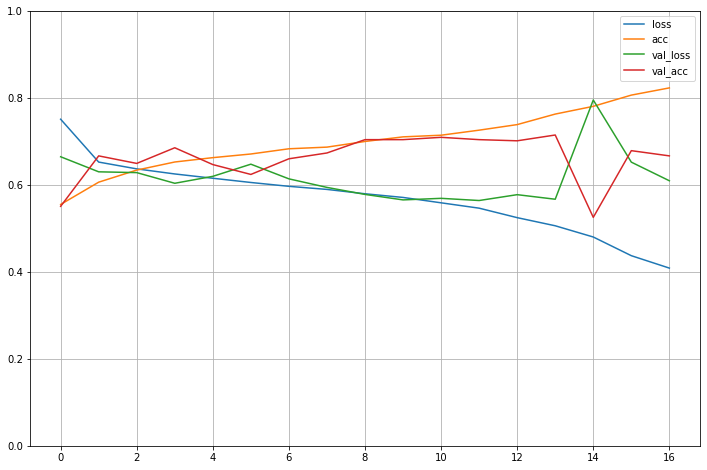

In [23]:
model_eval(history)

In [24]:
cnn_metrics(model)

Train Loss: 49.219%
Train Accuracy: 76.520%
Test Loss: 58.730%
Test Accuracy: 69.200%


In [25]:
model.save('cnn1.h5')

## Neural Network Results:

In [ ]:
# Making the predictions
training_preds = model.predict(train_images)
test_preds = model.predict(test_images)

In [124]:
# Setting a threshold and reorienting the predictions:
threshold = .6
# Creating a new list
test_preds_ii = []
# Looping through an appending as a binary value
for pred in test_preds:
    if pred >= threshold:
        test_preds_ii.append([1])
    else:
        test_preds_ii.append([0])
# Changing to a numpy array       
test_preds_ii = np.array(test_preds_ii)

# Same as above but for the training predictions
train_preds_ii = []

for pred in training_preds:
    if pred >= threshold:
        train_preds_ii.append([1])
    else:
        train_preds_ii.append([0])
        
train_preds_ii = np.array(train_preds_ii)

In [128]:
# Creating the confusion matrices
conf_mat_train = confusion_matrix(train_y, train_preds_ii)
conf_mat_test = confusion_matrix(test_y, test_preds_ii)
    
# Collecting true positives, true negatives, false positives, and false negatives
wf_tp_train = conf_mat_train[0,0]
wf_tn_train = conf_mat_train[1,1]
wf_fp_train = conf_mat_train[1,0]
wf_fn_train = conf_mat_train[0,1]

wf_tp_test = conf_mat_test[0,0]
wf_tn_test = conf_mat_test[1,1]
wf_fp_test = conf_mat_test[1,0]
wf_fn_test = conf_mat_test[0,1]

# Collecting Precision and Recall for train and test:
train_wf_recall = wf_tp_train / (wf_tp_train + wf_fn_train)
train_wf_precision = wf_tp_train / (wf_tp_train + wf_fp_train)

test_wf_recall = wf_tp_test / (wf_tp_test + wf_fn_test)
test_wf_precision = wf_tp_test / (wf_tp_test + wf_fp_test)

# Creating functions to show the confusion matrices and other results:
def conf_matrix_train():
    print ('0 = Wildfire\n1 = No Wildfire\n')

    # Plotting the first matrix
    plt.figure(figsize = (7,6))
    sns.heatmap(conf_mat_train, cmap = 'Blues', linecolor = 'black', linewidth = 1, annot = True, fmt = '')
    plt.title('Confusion Matrix - Train')
    plt.xlabel('Predicted', fontsize = 12)
    plt.ylabel('True', fontsize = 12)
    plt.show
    print('Wildfire Precision - Training:', "{:.2%}".format(train_wf_precision))
    print('Wildfire Recall - Training:', "{:.2%}".format(train_wf_recall))
     
def conf_matrix_test():
    # and the second
    print ('0 = Wildfire\n1 = No Wildfire\n')
    plt.figure(figsize = (7,6))
    sns.heatmap(conf_mat_test, cmap = 'Blues', linecolor = 'black', linewidth = 1, annot = True, fmt = '')
    plt.title('Confusion Matrix - Train')
    plt.xlabel('Predicted', fontsize = 12)
    plt.ylabel('True', fontsize = 12)
    plt.show
    print('Wildfire Precision - Testing:', "{:.2%}".format(test_wf_precision))
    print('Wildfire Recall - Testing:', "{:.2%}".format(test_wf_recall))

0 = Wildfire
1 = No Wildfire

Wildfire Precision - Training: 71.07%
Wildfire Recall - Training: 86.73%


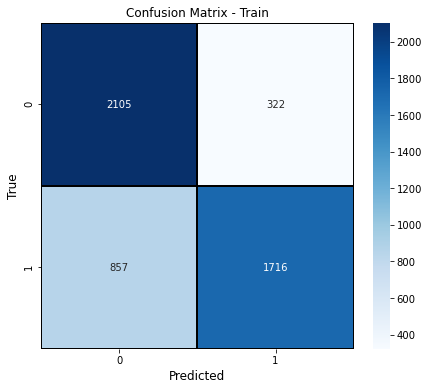

In [129]:
conf_matrix_train()

0 = Wildfire
1 = No Wildfire

Wildfire Precision - Testing: 63.32%
Wildfire Recall - Testing: 77.96%


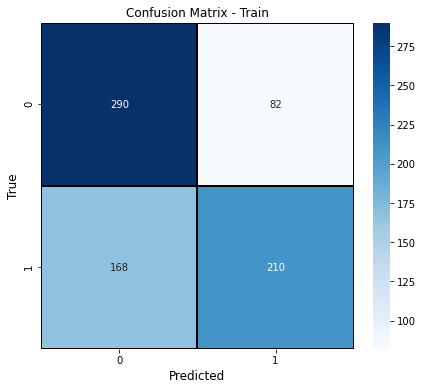

In [130]:
conf_matrix_test()

# Conclusion:

The above model turned out better than I had hoped. It had a high false positive rate rate, especially with the testing set, but given how much of Washington is full of relatively dry forest, I think it's reasonable for the model to recognize these areas at high risk, even if they've never had a wildfire started there. It seems like there was a bit of 'cross-contamination' between the wildfire set and non-wildfire set, given how an area in the non-wildfire set may be at risk of fire, despite it never having been on fire before.

In the future, I can revisit this with some new types of data and see if the model performs better. In the long run, I would love to see an improved version of this model put into deployment through state and local governments to keep tabs on their forests through live satellite feeds being analyzed through the neural network.  It would bea  tremendous way to identify new areas at risk and mitigate the risk of fire before it's set.

Thanks for checking out the repo, and let me know if you have any questions!

-Thomas